In [95]:
num_clients = 100
distribution_type = 'non_iid'  
root_percentage = 0.1  
root_client = True


# Split into Dist

In [96]:
import os
import struct
import numpy as np
from sklearn.model_selection import train_test_split

def LoadMNIST(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels.idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images.idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        struct.unpack('>II', lbpath.read(8))  # Unused magic number and count
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        struct.unpack('>IIII', imgpath.read(16))  # Unused magic number and dimensions
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

mnist_path = 'mnist'
x_train, y_train = LoadMNIST(mnist_path, kind='train')
x_test, y_test = LoadMNIST(mnist_path, kind='t10k')
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=10000, random_state=42)
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("Training data:", x_train.shape, y_train.shape)
print("Validation data:", x_valid.shape, y_valid.shape)
print("Test data:", x_test.shape, y_test.shape)


Training data: (50000, 28, 28, 1) (50000,)
Validation data: (10000, 28, 28, 1) (10000,)
Test data: (10000, 28, 28, 1) (10000,)


Root Data samples
[ 8 29 30 20 23  5  0  0 25 40]
Root Client assigned: 98


/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_29726/1722090128.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')
/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_29726/1722090128.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


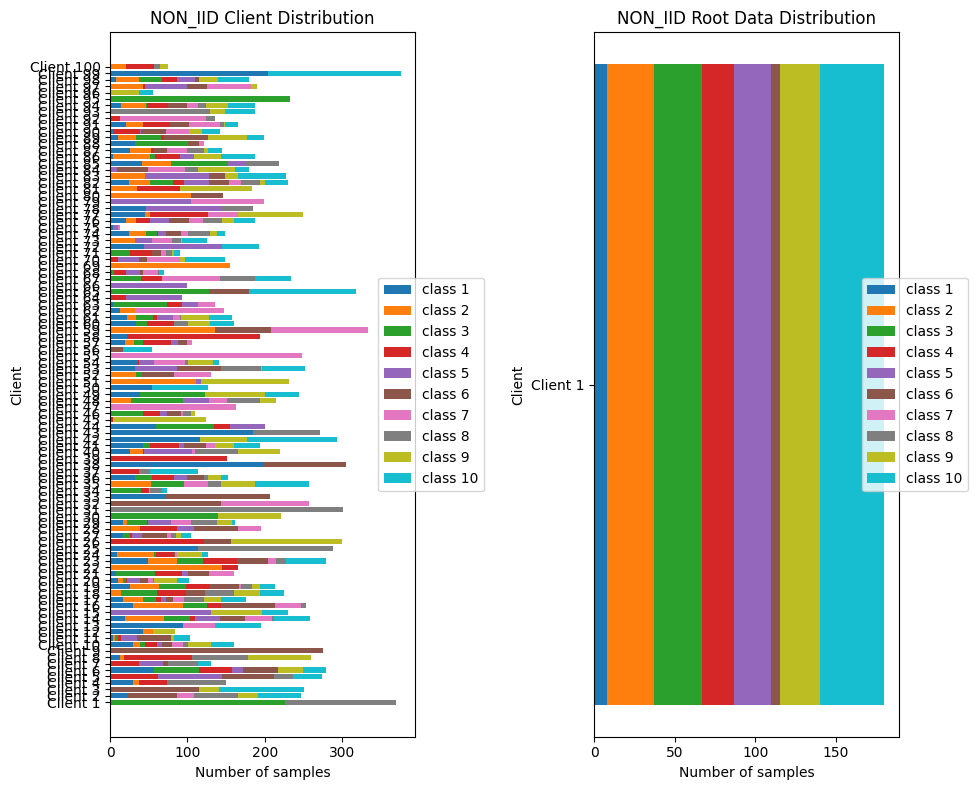

Root Data: 10 samples
[ 8 29 30 20 23  5  0  0 25 40]


In [99]:
import os
import numpy as np
import random

class FederatedDataSplitter:
    def __init__(self, x_train, y_train, x_test, y_test, num_clients=10, distribution='iid', dataset_dir='dataset', root_client=False, root_percentage=0.1):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.num_clients = num_clients
        self.distribution = distribution
        self.dataset_dir = dataset_dir
        self.root_client = root_client
        self.client_distributions = []
        self.root_distribution = []
        self.root_percentage = root_percentage

    def SplitData(self):
        os.makedirs(self.dataset_dir, exist_ok=True)
        client_data = []

        if self.distribution == 'iid':
            self.IIDSplit(client_data)
        else:
            self.NonIIDSplit(client_data)

        if self.root_client:
            self.AssignRootData(client_data)
        else:
            self.AssignRootDataAsSubset()

        self.SaveTestData()

    def IIDSplit(self, client_data):
        x_train_clients = self.x_train
        y_train_clients = self.y_train
        split_sizes = [len(x_train_clients) // self.num_clients] * self.num_clients
        if sum(split_sizes) != len(x_train_clients):
            split_sizes[-1] += len(x_train_clients) - sum(split_sizes)

        start_idx = 0
        for i in range(self.num_clients):
            end_idx = start_idx + split_sizes[i]
            x_client = x_train_clients[start_idx:end_idx]
            y_client = y_train_clients[start_idx:end_idx]
            start_idx = end_idx

            client_data.append((x_client, y_client))
            self.SaveClientData(x_client, y_client, client_id=i + 1)
            self.client_distributions.append(np.bincount(y_client, minlength=10))

    def NonIIDSplit(self, client_data):
        total_samples = len(self.x_train)
        indices = np.arange(total_samples)
        np.random.shuffle(indices)
        classes = np.unique(self.y_train)

        for i in range(self.num_clients):
            num_samples = random.randint(total_samples // (self.num_clients * 2), total_samples // self.num_clients)
            x_client, y_client = [], []
            selected_classes = np.random.choice(classes, size=random.randint(1, len(classes)), replace=False)

            for cls in selected_classes:
                class_indices = indices[self.y_train[indices] == cls]
                num_class_samples = random.randint(1, num_samples // len(selected_classes))
                chosen_indices = np.random.choice(class_indices, size=min(num_class_samples, len(class_indices)), replace=False)
                x_client.extend(self.x_train[chosen_indices])
                y_client.extend(self.y_train[chosen_indices])

            client_data.append((np.array(x_client), np.array(y_client)))
            self.SaveClientData(np.array(x_client), np.array(y_client), client_id=i + 1)
            self.client_distributions.append(np.bincount(y_client, minlength=10))

    def AssignRootDataAsSubset(self):
        total_samples = int(len(self.x_train) * self.root_percentage)
        indices = np.random.choice(len(self.x_train), size=total_samples, replace=False)
        x_root = self.x_train[indices]
        y_root = self.y_train[indices]
        self.SaveRootData(x_root, y_root)
        self.root_distribution = np.bincount(y_root, minlength=10)

    def AssignRootData(self, client_data):
        random_client_id = np.random.randint(0, self.num_clients)
        x_root, y_root = client_data[random_client_id]
        self.SaveRootData(x_root, y_root)
        self.root_distribution = np.bincount(y_root, minlength=10)
        print(f'Root Client assigned: {random_client_id + 1}')

    def SaveClientData(self, x_client, y_client, client_id):
        client_dir = os.path.join(self.dataset_dir, f'client_{client_id}')
        os.makedirs(client_dir, exist_ok=True)
        np.save(os.path.join(client_dir, 'x_data.npy'), x_client)
        np.save(os.path.join(client_dir, 'y_data.npy'), y_client)

    def SaveTestData(self):
        test_dir = os.path.join(self.dataset_dir, 'test')
        os.makedirs(test_dir, exist_ok=True)
        np.save(os.path.join(test_dir, 'x_test.npy'), self.x_test)
        np.save(os.path.join(test_dir, 'y_test.npy'), self.y_test)

    def SaveRootData(self, x_root, y_root):
        root_dir = os.path.join(self.dataset_dir, 'root')
        os.makedirs(root_dir, exist_ok=True)
        np.save(os.path.join(root_dir, 'x_data.npy'), x_root)
        np.save(os.path.join(root_dir, 'y_data.npy'), y_root)
        print(f'Root Data samples')
        print(np.bincount(y_root, minlength=10))


    @staticmethod
    def PlotDistributions(client_dist, root_dist, num_clients, title, root_client=False, root_assigned_client=None):
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        FederatedDataSplitter.PlotSampleStats(client_dist, num_clients, root_client=root_client, root_assigned_client=root_assigned_client)
        plt.title(f'{title} Client Distribution')
        if not root_client:
            plt.subplot(1, 2, 2)
            FederatedDataSplitter.PlotSampleStats([root_dist], 1)
            plt.title(f'{title} Root Data Distribution')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def PlotSampleStats(dist, num_clients, root_client=False, root_assigned_client=None):
        colors = plt.cm.get_cmap('tab10')
        if num_clients == 1:
            classes = [f'class {i + 1}' for i in range(len(dist[0]))]
            left = 0
            for i in range(len(classes)):
                plt.barh(0, dist[0][i], left=left, color=colors(i), label=classes[i])
                left += dist[0][i]
        else:
            classes = [f'class {i + 1}' for i in range(len(dist[0]))]
            left = np.zeros(num_clients)
            for i in range(len(classes)):
                plt.barh(range(num_clients), [dist[j][i] for j in range(num_clients)],
                         left=left, color=colors(i), label=classes[i])
                left += [dist[j][i] for j in range(num_clients)]
            if root_client and root_assigned_client is not None:
                plt.barh(root_assigned_client - 1, sum(dist[root_assigned_client - 1]), color='red', alpha=0.3, label="Root Client")
        plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
        plt.yticks(range(num_clients), [f'Client {i + 1}' for i in range(num_clients)])
        plt.xlabel('Number of samples')
        plt.ylabel('Client')


splitter = FederatedDataSplitter(x_train, y_train, x_test, y_test,
                                  num_clients=num_clients, 
                                  dataset_dir='dataset',
                                  distribution=distribution_type,
                                  root_client=root_client,
                                  root_percentage=root_percentage)

splitter.SplitData()
splitter.PlotDistributions(splitter.client_distributions, splitter.root_distribution, splitter.num_clients, splitter.distribution.upper())
#Print number of samples and number of samples per class in root data
print(f'Root Data: {len(splitter.root_distribution)} samples')
print(splitter.root_distribution)



# CIFAR

In [100]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations for the training and testing sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Example: Iterate through the DataLoader
# for images, labels in trainloader:
#     # Your training code here
#     pass

# Print the size of the dataset
print(f'Train set size: {len(trainset)}')
print(f'Test set size: {len(testset)}')


100%|██████████| 170498071/170498071 [00:40<00:00, 4167047.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train set size: 50000
Test set size: 10000


Files already downloaded and verified
Files already downloaded and verified
Root Data samples: [1017  963 1021  975  974 1011 1034  993  986 1026]


/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_29726/30666127.py:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')
/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_29726/30666127.py:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


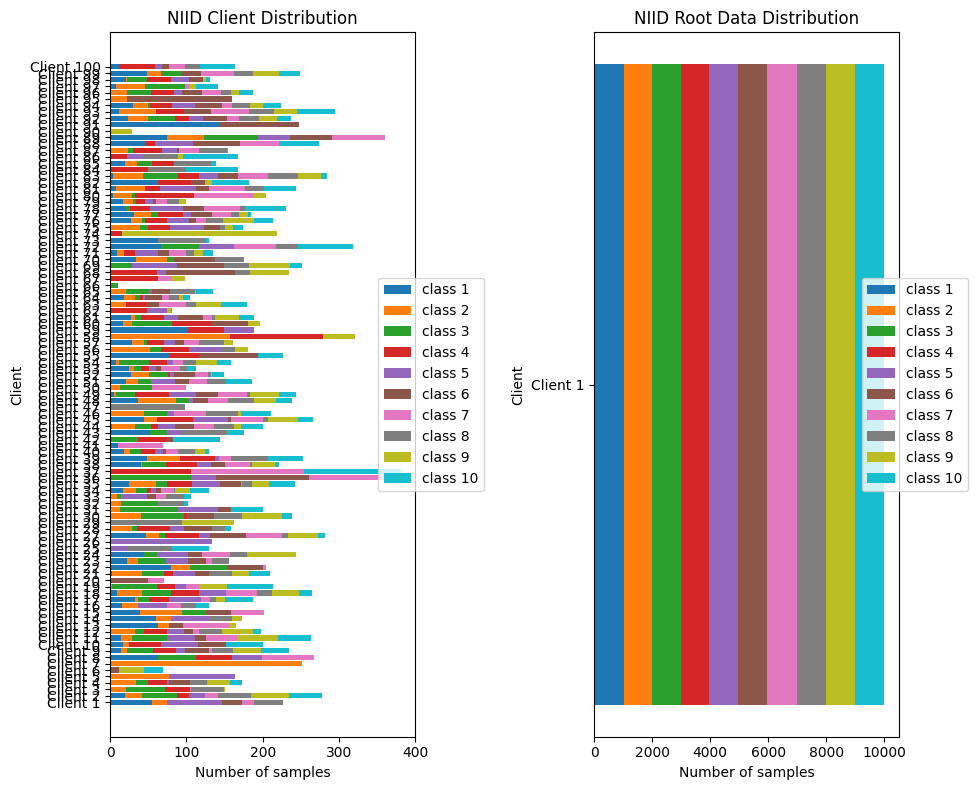

In [105]:
import os
import numpy as np
import random
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

class FederatedDataSplitter:
    def __init__(self, num_clients=10, distribution='iid', dataset_dir='dataset', root_client=False, root_percentage=0.1):
        self.num_clients = num_clients
        self.distribution = distribution
        self.dataset_dir = dataset_dir
        self.root_client = root_client
        self.root_percentage = root_percentage
        self.client_distributions = []
        self.root_distribution = []

        # Load CIFAR-10 dataset
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
        self.trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        self.testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

        self.x_train, self.y_train = self.trainset.data, np.array(self.trainset.targets)
        self.x_test, self.y_test = self.testset.data, np.array(self.testset.targets)

    def SplitData(self):
        os.makedirs(self.dataset_dir, exist_ok=True)
        client_data = []

        if self.distribution == 'iid':
            self.IIDSplit(client_data)
        else:
            self.NonIIDSplit(client_data)

        if self.root_client:
            self.AssignRootData(client_data)
        else:
            self.AssignRootDataAsSubset()

        self.SaveTestData()

    def IIDSplit(self, client_data):
        total_samples = len(self.x_train)
        indices = np.arange(total_samples)
        np.random.shuffle(indices)
        split_sizes = [total_samples // self.num_clients] * self.num_clients
        if sum(split_sizes) != total_samples:
            split_sizes[-1] += total_samples - sum(split_sizes)

        start_idx = 0
        for i in range(self.num_clients):
            end_idx = start_idx + split_sizes[i]
            client_indices = indices[start_idx:end_idx]
            x_client = self.x_train[client_indices]
            y_client = self.y_train[client_indices]
            start_idx = end_idx

            client_data.append((x_client, y_client))
            self.SaveClientData(x_client, y_client, client_id=i + 1)
            self.client_distributions.append(np.bincount(y_client, minlength=10))

    def NonIIDSplit(self, client_data):
        total_samples = len(self.x_train)
        indices = np.arange(total_samples)
        np.random.shuffle(indices)
        classes = np.unique(self.y_train)

        for i in range(self.num_clients):
            num_samples = random.randint(total_samples // (self.num_clients * 2), total_samples // self.num_clients)
            x_client, y_client = [], []
            selected_classes = np.random.choice(classes, size=random.randint(1, len(classes)), replace=False)

            for cls in selected_classes:
                class_indices = indices[self.y_train[indices] == cls]
                num_class_samples = random.randint(1, num_samples // len(selected_classes))
                chosen_indices = np.random.choice(class_indices, size=min(num_class_samples, len(class_indices)), replace=False)
                x_client.extend(self.x_train[chosen_indices])
                y_client.extend(self.y_train[chosen_indices])

            client_data.append((np.array(x_client), np.array(y_client)))
            self.SaveClientData(np.array(x_client), np.array(y_client), client_id=i + 1)
            self.client_distributions.append(np.bincount(y_client, minlength=10))

    def AssignRootDataAsSubset(self):
        total_samples = int(len(self.x_train) * self.root_percentage)
        indices = np.random.choice(len(self.x_train), size=total_samples, replace=False)
        x_root = self.x_train[indices]
        y_root = self.y_train[indices]
        self.SaveRootData(x_root, y_root)
        self.root_distribution = np.bincount(y_root, minlength=10)

    def AssignRootData(self, client_data):
        random_client_id = np.random.randint(0, self.num_clients)
        x_root, y_root = client_data[random_client_id]
        self.SaveRootData(x_root, y_root)
        self.root_distribution = np.bincount(y_root, minlength=10)
        print(f'Root Client assigned: {random_client_id + 1}')

    def SaveClientData(self, x_client, y_client, client_id):
        client_dir = os.path.join(self.dataset_dir, f'client_{client_id}')
        os.makedirs(client_dir, exist_ok=True)
        np.save(os.path.join(client_dir, 'x_data.npy'), x_client)
        np.save(os.path.join(client_dir, 'y_data.npy'), y_client)

    def SaveTestData(self):
        test_dir = os.path.join(self.dataset_dir, 'test')
        os.makedirs(test_dir, exist_ok=True)
        np.save(os.path.join(test_dir, 'x_test.npy'), self.x_test)
        np.save(os.path.join(test_dir, 'y_test.npy'), self.y_test)

    def SaveRootData(self, x_root, y_root):
        root_dir = os.path.join(self.dataset_dir, 'root')
        os.makedirs(root_dir, exist_ok=True)
        np.save(os.path.join(root_dir, 'x_data.npy'), x_root)
        np.save(os.path.join(root_dir, 'y_data.npy'), y_root)
        print(f'Root Data samples: {np.bincount(y_root, minlength=10)}')

    @staticmethod
    def PlotDistributions(client_dist, root_dist, num_clients, title, root_client=False, root_assigned_client=None):
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        FederatedDataSplitter.PlotSampleStats(client_dist, num_clients, root_client=root_client, root_assigned_client=root_assigned_client)
        plt.title(f'{title} Client Distribution')
        if not root_client:
            plt.subplot(1, 2, 2)
            FederatedDataSplitter.PlotSampleStats([root_dist], 1)
            plt.title(f'{title} Root Data Distribution')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def PlotSampleStats(dist, num_clients, root_client=False, root_assigned_client=None):
        colors = plt.cm.get_cmap('tab10')
        if num_clients == 1:
            classes = [f'class {i + 1}' for i in range(len(dist[0]))]
            left = 0
            for i in range(len(classes)):
                plt.barh(0, dist[0][i], left=left, color=colors(i), label=classes[i])
                left += dist[0][i]
        else:
            classes = [f'class {i + 1}' for i in range(len(dist[0]))]
            left = np.zeros(num_clients)
            for i in range(len(classes)):
                plt.barh(range(num_clients), [dist[j][i] for j in range(num_clients)],
                         left=left, color=colors(i), label=classes[i])
                left += [dist[j][i] for j in range(num_clients)]
            if root_client and root_assigned_client is not None:
                plt.barh(root_assigned_client - 1, sum(dist[root_assigned_client - 1]), color='red', alpha=0.3, label="Root Client")
        plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
        plt.yticks(range(num_clients), [f'Client {i + 1}' for i in range(num_clients)])
        plt.xlabel('Number of samples')
        plt.ylabel('Client')

splitter = FederatedDataSplitter(num_clients=100, distribution='niid', root_client=False, root_percentage=0.2)
splitter.SplitData()
splitter.PlotDistributions(splitter.client_distributions, splitter.root_distribution, splitter.num_clients, splitter.distribution.upper())


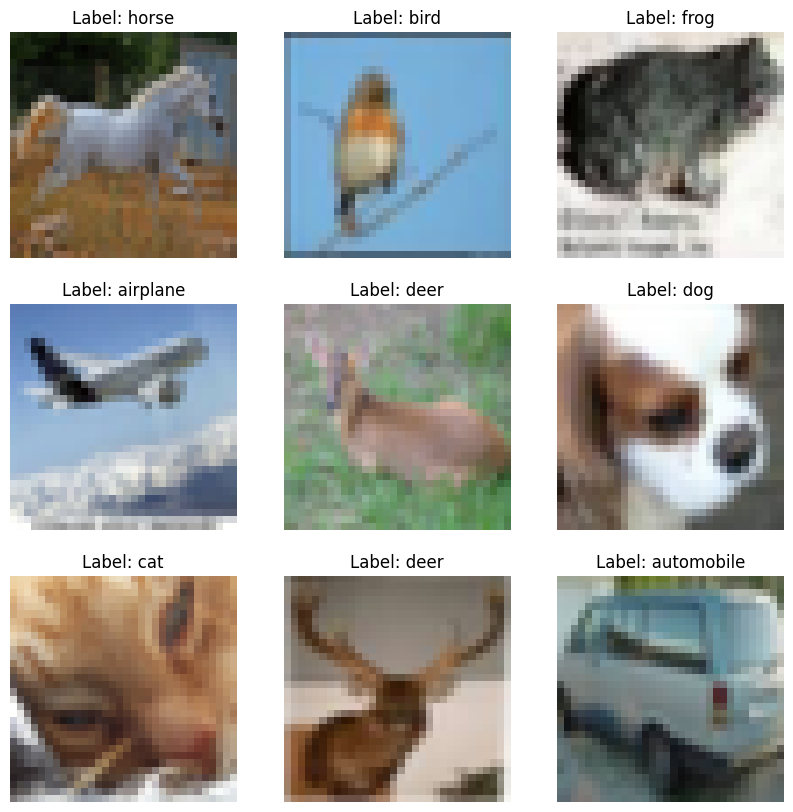

In [103]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Define a function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    imshow(images[i])
    plt.title(f'Label: {trainset.classes[labels[i]]}')
plt.show()